# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

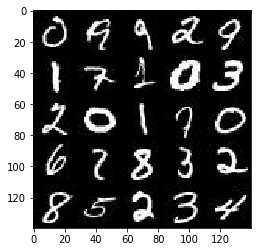

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

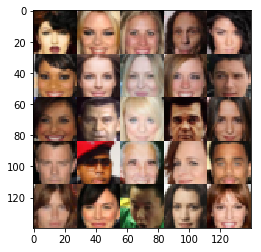

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer 28x28x(1 or 3)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        # 28x28xout_channel_dim
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)  * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in all_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    out_channel_dim = data_shape[3]
    _, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4889... Generator Loss: 14.4373
Epoch 1/2... Discriminator Loss: 0.5045... Generator Loss: 4.2166
Epoch 1/2... Discriminator Loss: 0.7055... Generator Loss: 2.4247
Epoch 1/2... Discriminator Loss: 0.6936... Generator Loss: 2.4865
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 1.6132
Epoch 1/2... Discriminator Loss: 1.5326... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 2.8650
Epoch 1/2... Discriminator Loss: 1.7418... Generator Loss: 2.2540
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 1.7880


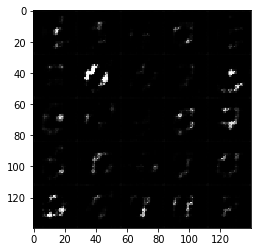

Epoch 1/2... Discriminator Loss: 1.9857... Generator Loss: 0.3351
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 1.7811
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.4535
Epoch 1/2... Discriminator Loss: 1.7620... Generator Loss: 2.5174
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 1.3494
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.6704
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 0.5550
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 1.6677


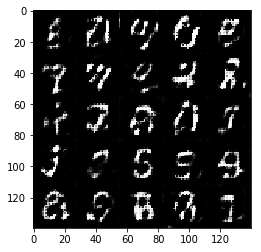

Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 1.9749
Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 1.3597
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 1.3703
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 1.7847
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 1.5933... Generator Loss: 0.4167
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 1.3988
Epoch 1/2... Discriminator Loss: 1.8717... Generator Loss: 3.1219


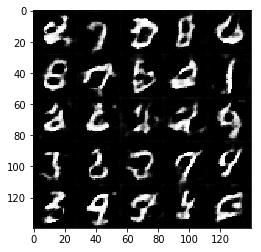

Epoch 1/2... Discriminator Loss: 1.0188... Generator Loss: 1.0465
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 1.5001
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 2.1747
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.8357
Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 1.3261
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 1.8113
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.9249


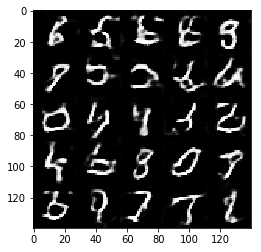

Epoch 1/2... Discriminator Loss: 1.4806... Generator Loss: 1.7741
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 1.0667
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 1.5242
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 1.5528
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.4779
Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 1.0308
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.3970... Generator Loss: 1.7597
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.6326


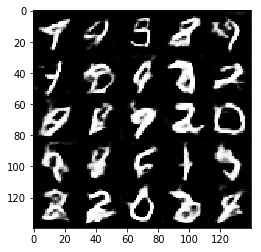

Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 1.3646
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 1.1589
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.6317
Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.9444
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 1.6559
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.6143
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 1.0447


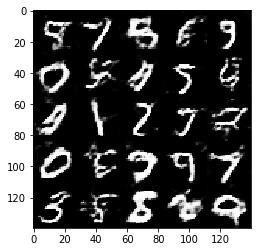

Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 1.3179
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.6278
Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: 0.5115
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 1.3493
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.5034... Generator Loss: 2.1003
Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 1.3389


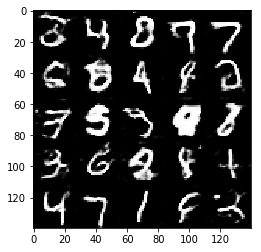

Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 1.0863
Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 1.3540
Epoch 2/2... Discriminator Loss: 1.0630... Generator Loss: 1.1873
Epoch 2/2... Discriminator Loss: 1.6745... Generator Loss: 0.3994
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 1.2321
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 1.5401
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.8959
Epoch 2/2... Discriminator Loss: 1.5233... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.9431


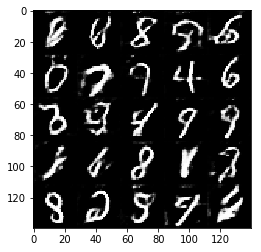

Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.8947
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.7094
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 1.4480
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 1.4725... Generator Loss: 1.5027
Epoch 2/2... Discriminator Loss: 1.2101... Generator Loss: 0.9293
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 1.0836
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.8718


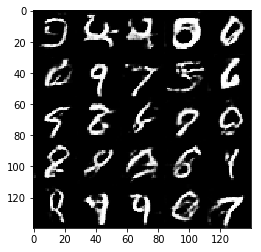

Epoch 2/2... Discriminator Loss: 1.4993... Generator Loss: 1.9517
Epoch 2/2... Discriminator Loss: 1.1487... Generator Loss: 1.0326
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 1.1112


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.8991... Generator Loss: 0.2904
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 1.5124
Epoch 1/1... Discriminator Loss: 1.7163... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.7690


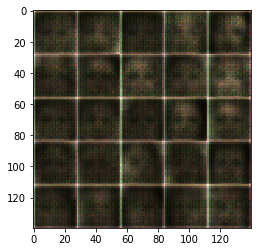

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 2.0815... Generator Loss: 0.3488
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 1.8313


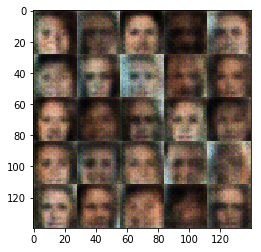

Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 1.7133
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.8317
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 0.3828
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.6042
Epoch 1/1... Discriminator Loss: 2.1485... Generator Loss: 3.5218
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.8371


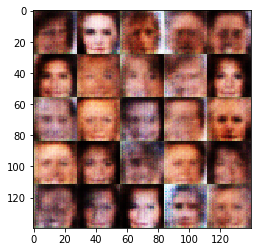

Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 2.0111... Generator Loss: 0.3001
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 2.2602
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7820


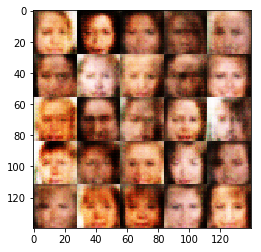

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7864


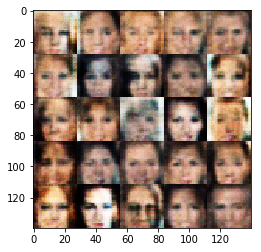

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8105


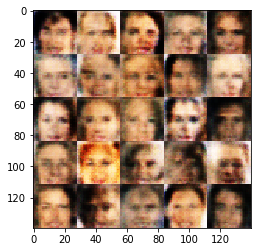

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7966


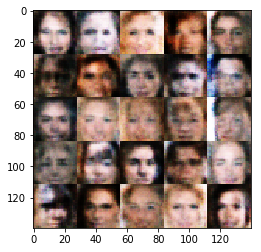

Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8118


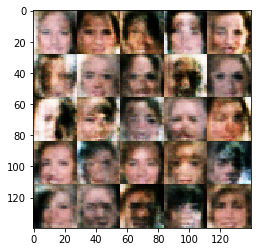

Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7469


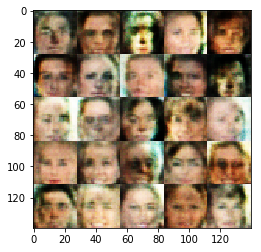

Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.9171


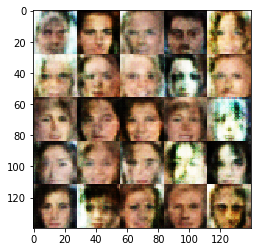

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7824


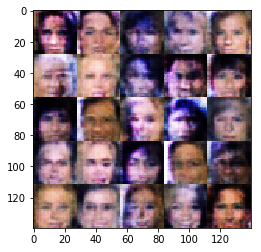

Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.8100


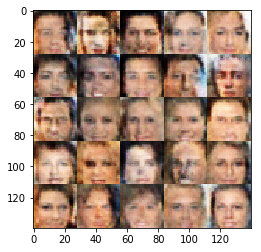

Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7563


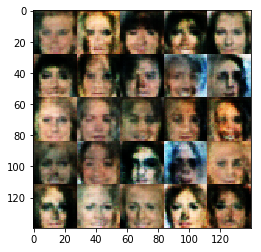

Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.7316
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 1.4167
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.6302
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 1.6458... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8839


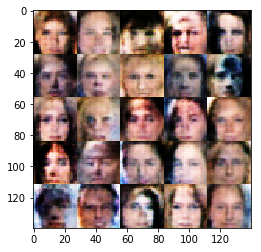

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.9025... Generator Loss: 0.2580
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.2364


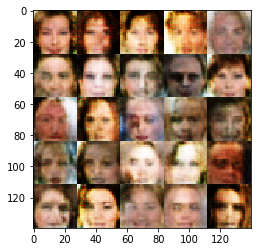

Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.9391


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.